In [1]:
import dicom # The only library for reading dicom files
import os # for doing directory operations 
import pandas as pd # To load data in the labels data and quickly reference it
import pprint
import math
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


/home/sdash/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING O
#N KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER

data_dir = '/scratch2/sdash/data/stage1'
patients = os.listdir(data_dir)
patients.sort()
#print(patients[0])
labels_df = pd.read_csv('/scratch2/sdash/data/stage1_labels.csv', index_col=0)
print(cv2.__version__)

labels_df.head()

3.2.0


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [3]:
min_slices = 0

for patient in patients[:5]:
    #print(patient) #SDebug:
    try:
        label = labels_df.get_value(patient,'cancer')
        #print(len(labels_df))
        path = data_dir + '/' + patient

        #print(path)  #SDebug
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        
        #finding the minimum fo slices
        if min_slices==0:
            min_slices = len(slices)
        if(len(slices) < min_slices ):
            min_slices = len(slices)
        
        print(len(slices),label)
        print(len(slices),slices[1].pixel_array.shape)   #Number ofo Slices,Rows pixel size, Columns pixe size
        #print(slices[0])
        print(" ")
    except:
        print(patient + " Key not found")
    #STodo: we have to visualize the positive cases and the negative cases

(195, 1)
(195, (512, 512))
 
(265, 0)
(265, (512, 512))
 
(233, 0)
(233, (512, 512))
 
(173, 1)
(173, (512, 512))
 
(146, 1)
(146, (512, 512))
 


In [9]:
print(min_slices)

146


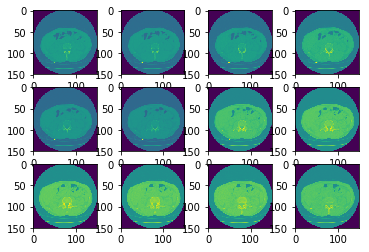

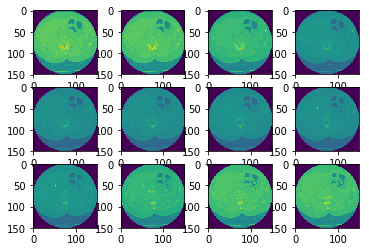

In [4]:
#just visualizing the images
IMG_PX_SIZE = 150

for patient in patients[:2]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + '/' + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [5]:
def chunks(l, n):
    #print(int(n))
    for i in xrange(0, len(l), int(n)): yield l[i:i + int(n)]
        

In [6]:
def mean(l):
    return sum(l) / len(l)


In [7]:
label = labels_df.get_value(patient, 'cancer')
label

0

In [8]:
def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + '/' + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in list(chunks(slices, chunk_sizes)):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    #len(new_slices is less than hm_slices)
    if( len(new_slices) < hm_slices ):
        for i in range(len(new_slices),hm_slices):
            new_slices.append(new_slices[len(new_slices)])
    elif(len(new_slices) > hm_slices):
        #print("length =")
        #print(len(new_slices))
        new_slices = new_slices[0:hm_slices]
    
    #print(len(new_slices))
    
    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

In [9]:
def process_image_data(patient3DSlices,CancerOneHotlabel,img_px_size=64, hm_slices=20, visualize=False):
    
    new_slices = []
    #Resizing to smaller images
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in patient3DSlices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in list(chunks(slices, chunk_sizes)):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    #len(new_slices is less than hm_slices)
    if( len(new_slices) < hm_slices ):
        for i in range(len(new_slices),hm_slices):
            new_slices.append(new_slices[len(new_slices)])
    elif(len(new_slices) > hm_slices):
        #print("length =")
        #print(len(new_slices))
        new_slices = new_slices[0:hm_slices]
    
    #print(len(new_slices))
    
    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    #if label == 1: label=np.array([0,1])
    #elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),CancerOneHotlabel

2


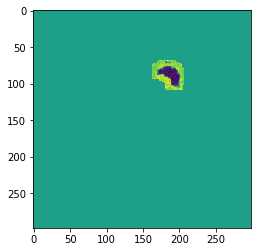

In [10]:
much_data = np.load('TesnsorflowData.npy')
print(len(much_data))
#print(much_data)
plt.imshow(much_data[1][0][1])

In [11]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

nolabel = 0
much_data = np.load('muchdata-50-50-20.npy')
for num,patient in enumerate(patients):
    if num % 50 == 0:
        print(num)
    try:
        #img_data,label = process_data(patient,labels_df,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT,visualize=True)
        patient_resizedImage,label = process_data(patient,labels_df,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        #print("length img_data = ",len(img_data))
        much_data.append([patient_resizedImage,label])
    except KeyError as e:
        #print(e)
        #print('This is unlabeled data!')
        nolabel=nolabel+1

print(nolabel)
np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [12]:
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np

IMG_SIZE_PX = 64
SLICE_COUNT = 32

n_classes = 2
batch_size = 100

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [13]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')


In [14]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,5,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([5,5,5,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([131072,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 131072])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output


In [15]:
#Loading of our data 

load_data = np.load('TensorflowData.npy')
load_data1 = np.load('TensorflowData1.npy')
load_data2 = np.load('TensorflowData2.npy')
load_data3 = np.load('TensorflowData3.npy')

print(load_data.shape)
print(load_data1.shape)
final_data = np.append(load_data,load_data1,0)
print(final_data.shape)
print(load_data2.shape)
final_data = np.append(final_data,load_data2,0)
print(final_data.shape)
print(load_data3.shape)
final_data = np.append(final_data,load_data3,0)
print(final_data.shape)



(200, 3)
(299, 3)
(499, 3)
(249, 3)
(748, 3)
(646, 3)
(1394, 3)


In [ ]:
#much_data = np.load('muchdata-50-50-20.npy')
much_data = final_data

# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-200]
validation_data = much_data[-200:]


def train_neural_network(x):
    
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        #sess.run(tf.initialize_all_variables())
        sess.run(tf.global_variables_initializer())
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                    print(successful_runs) #for test
                except Exception as e:
                    print(str(e))
                    pass
                    
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

1
2
3
4
5
6


In [ ]:
import csv
    with open("stage1_label.csv", "r") as f1, \
     open("Stage2.csv", "w", newline='') as resultFile:
    wr = csv.writer(resultFile, dialect='excel')
    for var in f1:
        wr.writerow([var.rstrip('\n')])